# Continuous-attractor Neural Network

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

In [2]:
import brainpy as bp
import brainpy.math as bm

bm.set_platform('cpu')

## Model

In [3]:
class CANN1D(bp.NeuGroup):
  def __init__(self, num, tau=1., k=8.1, a=0.5, A=10., J0=4.,
               z_min=-bm.pi, z_max=bm.pi, **kwargs):
    super(CANN1D, self).__init__(size=num, **kwargs)

    # parameters
    self.tau = tau  # The synaptic time constant
    self.k = k  # Degree of the rescaled inhibition
    self.a = a  # Half-width of the range of excitatory connections
    self.A = A  # Magnitude of the external input
    self.J0 = J0  # maximum connection value

    # feature space
    self.z_min = z_min
    self.z_max = z_max
    self.z_range = z_max - z_min
    self.x = bm.linspace(z_min, z_max, num)  # The encoded feature values
    self.rho = num / self.z_range  # The neural density
    self.dx = self.z_range / num  # The stimulus density

    # variables
    self.u = bm.Variable(bm.zeros(num))
    self.input = bm.Variable(bm.zeros(num))

    # The connection matrix
    self.conn_mat = self.make_conn(self.x)

    # function
    self.integral = bp.odeint(self.derivative)

  def derivative(self, u, t, Iext):
    r1 = bm.square(u)
    r2 = 1.0 + self.k * bm.sum(r1)
    r = r1 / r2
    Irec = bm.dot(self.conn_mat, r)
    du = (-u + Irec + Iext) / self.tau
    return du

  def dist(self, d):
    d = bm.remainder(d, self.z_range)
    d = bm.where(d > 0.5 * self.z_range, d - self.z_range, d)
    return d

  def make_conn(self, x):
    assert bm.ndim(x) == 1
    x_left = bm.reshape(x, (-1, 1))
    x_right = bm.repeat(x.reshape((1, -1)), len(x), axis=0)
    d = self.dist(x_left - x_right)
    Jxx = self.J0 * bm.exp(-0.5 * bm.square(d / self.a)) / (bm.sqrt(2 * bm.pi) * self.a)
    return Jxx

  def get_stimulus_by_pos(self, pos):
    return self.A * bm.exp(-0.25 * bm.square(self.dist(self.x - pos) / self.a))

  def update(self, tdi):
    self.u.value = self.integral(self.u, tdi.t, self.input, tdi.t)
    self.input[:] = 0.

## Find fixed points

In [4]:
model = CANN1D(num=512, k=0.1, A=30, a=0.5)

In [5]:
candidates = model.get_stimulus_by_pos(bm.arange(-bm.pi, bm.pi, 0.005).reshape((-1, 1)))

finder = bp.analysis.SlowPointFinder(f_cell=model, target_vars={'u': model.u})
finder.find_fps_with_gd_method(
  candidates={'u': candidates},
  tolerance=1e-6,
  num_batch=200,
  optimizer=bp.optim.Adam(lr=bp.optim.ExponentialDecay(0.1, 2, 0.999)),
)
finder.filter_loss(1e-7)
finder.keep_unique()
# finder.exclude_outliers(tolerance=1e1)

print('Losses of fixed points:')
print(finder.losses)

Optimizing with Adam(lr=ExponentialDecay(0.1, decay_steps=2, decay_rate=0.999), last_call=-1), beta1=0.9, beta2=0.999, eps=1e-08) to find fixed points:
    Batches 1-200 in 2.85 sec, Training loss 0.0000000000
    Stop optimization as mean training loss 0.0000000000 is below tolerance 0.0000010000.
Excluding fixed points with squared speed above tolerance 1e-07:
    Kept 1257/1257 fixed points with tolerance under 1e-07.
Excluding non-unique fixed points:
    Kept 1257/1257 unique fixed points with uniqueness tolerance 0.025.
Losses of fixed points:
[0. 0. 0. ... 0. 0. 0.]


## Visualize fixed points

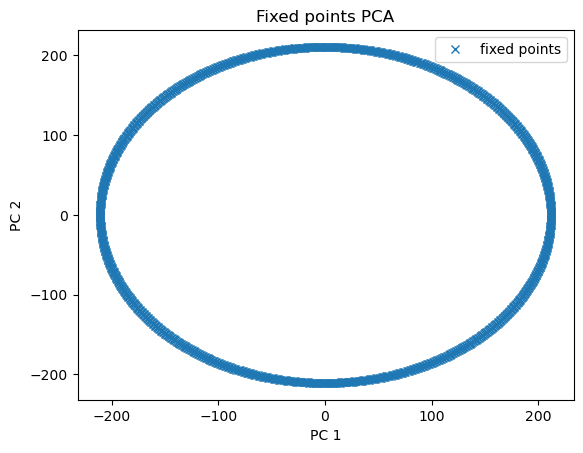

In [6]:
pca = PCA(2)
fp_pcs = pca.fit_transform(finder.fixed_points['u'])
plt.plot(fp_pcs[:, 0], fp_pcs[:, 1], 'x', label='fixed points')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Fixed points PCA')
plt.legend()
plt.show()

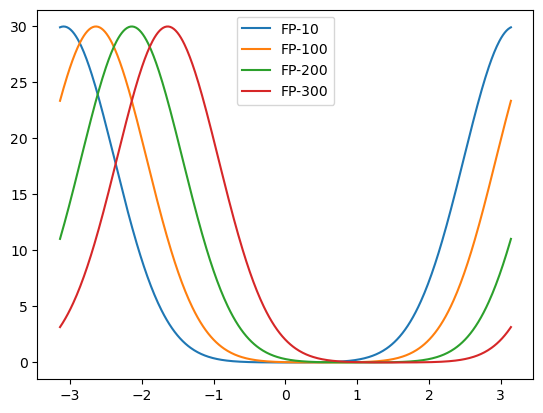

In [7]:
fps = finder.fixed_points['u']
plot_ids = (10, 100, 200, 300,)
plot_ids = np.asarray(plot_ids)

for i in plot_ids:
  plt.plot(model.x, fps[i], label=f'FP-{i}')
plt.legend()
plt.show()

## Verify the stabilities of fixed points

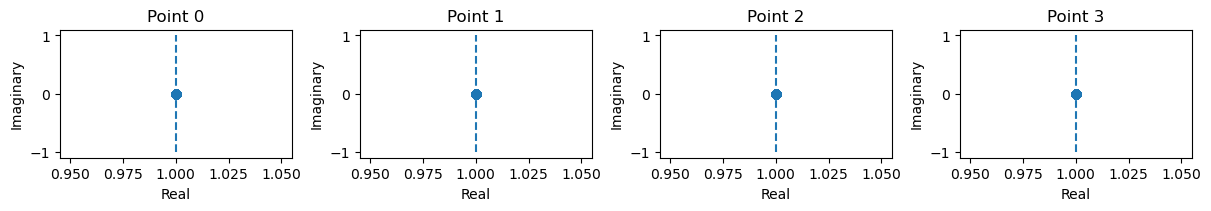

In [8]:
from jax.tree_util import tree_map

_ = finder.compute_jacobians(
  tree_map(lambda x: x[plot_ids], finder._fixed_points),
  plot=True
)